In [ ]:
# Simple simulation of metastasis to test the assumptions of the met-score metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import sklearn.metrics as sklm
from tqdm import tqdm_notebook
import scipy.stats as scs


import utilities.metastasis_sim_utils as met_sim
import utilities.metastasis_score_utils as met_utils

In [3]:
# define parameters:
N_clones = 1000 #number of clones to simulate
max_mu = 0.3 #max rate of metastasis
min_alpha = 0.75 #min rate of doubling
t_range = [12,16] #range of time-steps
sigma = 6 #number of tumor samples
beta = 0.00 #extinction rate

# make samples
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
sample_list = [alphabet[i] for i in range(sigma)]

# generate color list
cmap = plt.cm.get_cmap('Blues')
cmap_list = []
for i in range(len(sample_list)):
    cmap_list.append(cmap(i/len(sample_list)))

In [4]:
# make a masterDF of results
masterDF = met_sim.simulate_counts(sample_list, N_clones, max_mu, min_alpha, t_range, beta)

iterating over clones: 100%|██████████| 1000/1000 [00:22<00:00, 45.40it/s]


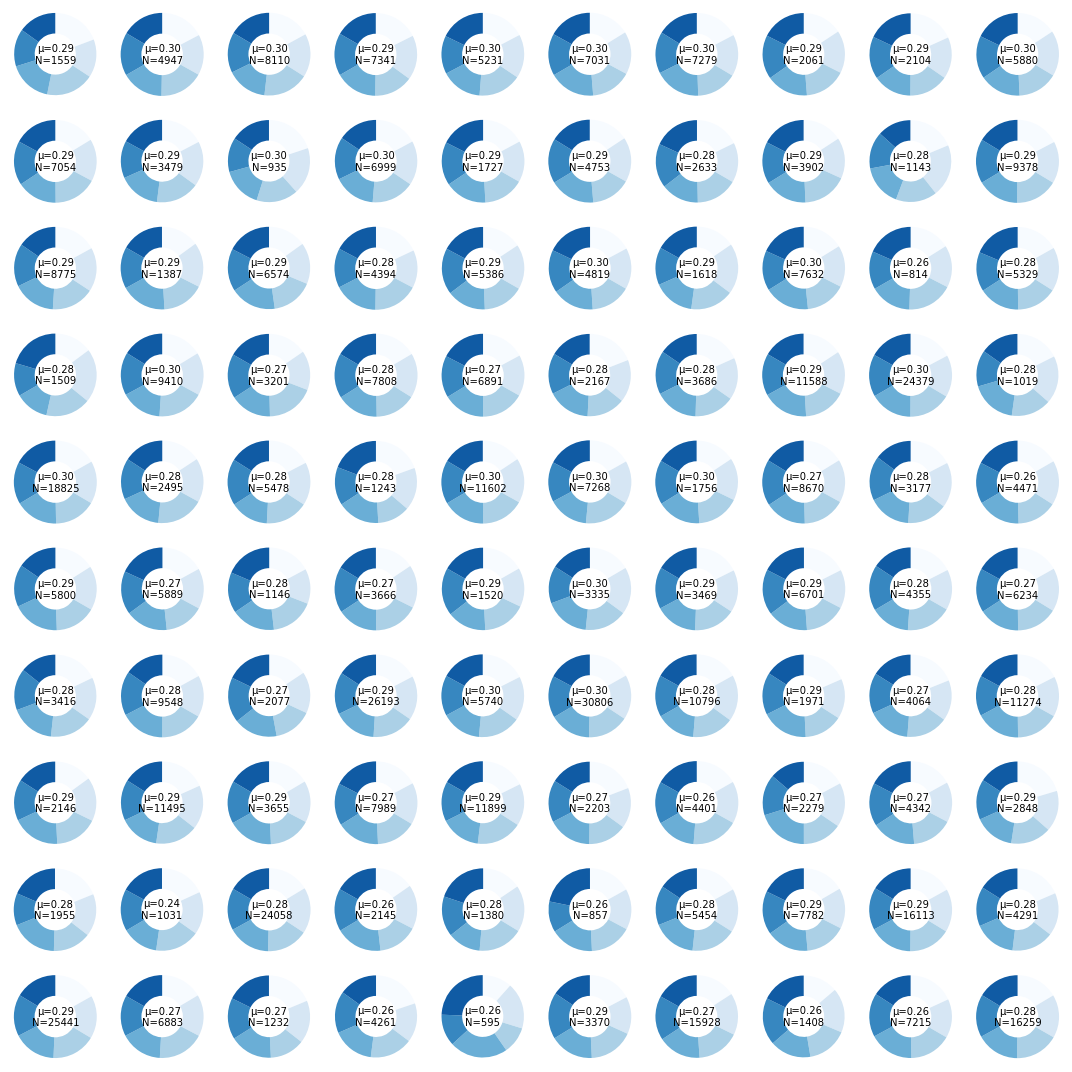

In [5]:
# Subplot distribution of UMI per cell per sample
f, axarr = plt.subplots(10, 10, figsize=(15,15))

for j in range(0,100):
    x = int((j)/10)
    y = int((j)%10)
    
    cellspersample = masterDF.iloc[j][sample_list].tolist()
    axarr[x,y].pie(cellspersample, colors=cmap_list, startangle=90, counterclock=False, wedgeprops=dict(width=0.5))
    axarr[x,y].text(0, 0, "µ="+"%.2f" % masterDF.iloc[j]['mu'] +"\nN="+str(masterDF.iloc[j]['N']), ha='center', va='center')
    axarr[x,y].axis('equal')
       
plt.tight_layout()

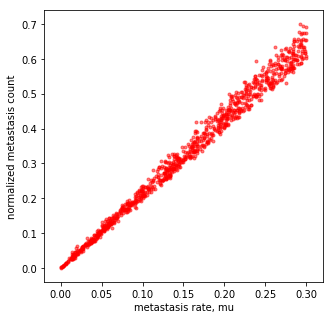

In [6]:
# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['Norm_mets'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('normalized metastasis count')

plt.savefig('sim_metcounts_vs_rate.png')

In [14]:
# Several issues:
# - how do you make a confusion matrix with different number of observations and expectations?
# - how do you calculate a Chi-sq when the expected is zero but observed is non-zero?

# find background distribution across all clones
background = masterDF.filter(sample_list, axis=1).sum(axis=0)

cramers_list = []
for k in tqdm_notebook(range(0,N_clones)):
    
    query = masterDF.iloc[k][sample_list]

    query = pd.DataFrame(query)

    table = pd.concat([background, query], axis=1)
    table.fillna(value = 0, inplace=True)
    table.columns = ["Background", "LG"]
    table["Background"] = table["Background"] - table["LG"]

    
    stat = scs.chi2_contingency(table)[0]
    v = met_utils.cramers_v(stat, np.sum(table.sum()), table.shape[0], table.shape[1])
    cramers_list.append(1 - v)
    
#     v = cramers_v(stat, np.sum(table.sum()), table.shape[0], table.shape[1])
    
#     # First, make an expanded list of the observed samples
#     obs = masterDF.iloc[k][sample_list]
#     obs_exp = []
#     for i in range(len(obs)):
#         for j in range(int(obs[i])):
#             obs_exp.append(sample_list[i])
            
#     # Next, make an expanded list of the expected samples (of the same dimension as the observed!?)  
#     pred_exp = []
#     progress = 0
#     for i in range(len(obs)):
#         progress += pred_norm[i]
#         while float(len(pred_exp))/len(obs_exp) < progress:
#             pred_exp.append(sample_list[i])
    
#     # make confusion matrix of predicted vs observed
#     confusion_matrix = sklm.confusion_matrix(obs_exp, pred_exp, labels=sample_list)
    
#     # calculate Cramers V and update
#     cramersV1 = cramers_corrected_stat(confusion_matrix)
#     #cramersV2 = cramers_stat(confusion_matrix)
#     cramers_list.append(cramersV1)

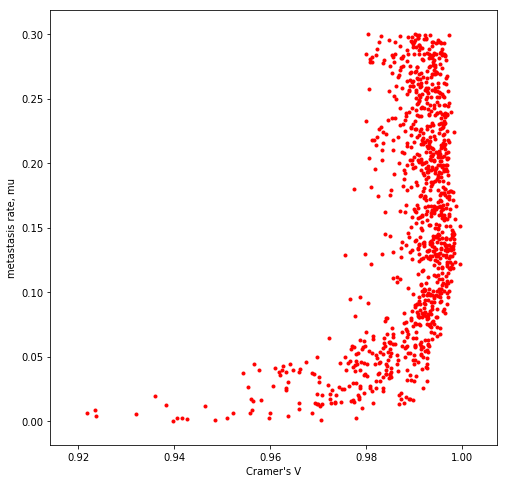

In [15]:
# plot distribution
h1 = plt.figure(1,figsize=(8,8))
scat = plt.scatter(cramers_list, masterDF.iloc[0:len(cramers_list)]['mu'], color='r', marker='.')
xlab = plt.ylabel('metastasis rate, mu')
ylab = plt.xlabel("Cramer's V")
plt.savefig('sim_evolving_vs_static.png')

plt.show()

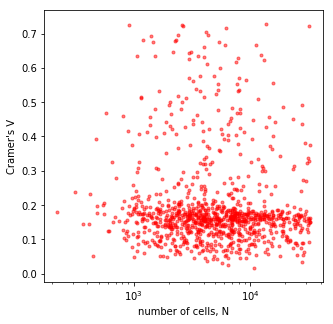

In [35]:
# plot correlation between number of cells and Cramers V
h2 = plt.figure(2,figsize=(5,5))
scat = plt.scatter(masterDF.iloc[0:len(cramers_list)]['N'], cramers_list, color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('number of cells, N')
ylab = plt.ylabel("Cramer's V")
xsca = plt.xscale("log")